## Single neuron from scratch 
**Goal:** Using *Alice in Wonderland* text, train a single neuron (logistic unit) from scratch (NumPy only) to classify whether a character is a vowel (`a,e,i,o,u`) or not.

This notebook demonstrates:
- loading & exploring a text file
- simple preprocessing (char-level)
- building a one-hot input representation
- implementing a single neuron (sigmoid)
- computing binary cross-entropy loss
- manual gradients and parameter updates (no autograd)
- training loop and evaluation


### Imports and configs

In [23]:
!pip install numpy matplotlib scikit-learn 


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 2.3 MB/s  0:00:03m 2.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 3.3 MB/s  0:00:06 eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn]0m 3/4 [scikit-learn]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

np.random.seed(42)

### Load the Txt File

In [5]:
path = "data/alice.txt"

with open(path, 'r',encoding='utf-8') as f:
    text = f.read()

print("Total characters in text:", len(text))
print("First 250 characters:")
print(text[:250])

Total characters in text: 148574
First 250 characters:
Alice's Adventures in Wonderland

                ALICE'S ADVENTURES IN WONDERLAND

                          Lewis Carroll

               THE MILLENNIUM FULCRUM EDITION 3.0




                            CHAPTER I

                      Down the R


We will lowercase the text and keep only a simple character-level vocabulary.
We will create a one-hot encoding for each character, and a binary label:
- label = 1 if character is a vowel (`a, e, i, o, u`)
- label = 0 otherwise

This is intentionally *very* simple so we can focus on the math.


In [8]:
text_clean = text.lower()

# Build character vocabulary (keep all characters we observe)
chars = sorted(list(set(text_clean)))
vocab_size = len(chars)
print("Vocab size (unique chars):", vocab_size)
print("Some characters:", chars[:50])

# Mappings
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for ch, i in char2idx.items()}


Vocab size (unique chars): 46
Some characters: ['\n', ' ', '!', '"', "'", '(', ')', '*', ',', '-', '.', '0', '3', ':', ';', '?', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


create dataset: one-hot X and binary y label for vowel



In [9]:
def is_vowel(ch):
    return 1 if ch in {"a","e","i","o","u"} else 0
# Build dataset arrays
chars_list = list(text_clean)
N = len(chars_list)
print(chars_list[:10], N)


['a', 'l', 'i', 'c', 'e', "'", 's', ' ', 'a', 'd'] 148574


In [18]:
# idxs = np.arange(N)
# print("First 10 indices:", idxs[:10])


max_samples = 50000   # set to None to use full text

if max_samples is not None and N > max_samples:
    # pick evenly spaced indices or random subset (here random)
    idxs = np.random.choice(N, size=max_samples, replace=False)
else:
    idxs = np.arange(N)



In [19]:
X = np.zeros((len(idxs), vocab_size), dtype=np.float32)  # one-hot
y = np.zeros((len(idxs),), dtype=np.float32)

print("One-hot X shape:", X.shape)
print("Label y shape:", y.shape)


One-hot X shape: (50000, 46)
Label y shape: (50000,)


In [ ]:
for i, idx in enumerate(idxs):
    ch = chars_list[idx]
    X[i, char2idx[ch]] = 1.0
    y[i] = is_vowel(ch)

print("Dataset size:", X.shape[0])


Dataset size: 50000
Example characters and labels:


In [21]:
print("Example characters and labels:")
for i in range(10):
    ch = chars_list[idxs[i]]
    print(i, repr(ch), "->", char2idx[ch], "label:", int(is_vowel(ch)))
    
# Class balance
print("\nClass distribution:", Counter(y.tolist()))




Example characters and labels:
0 'm' -> 32 label: 0
1 't' -> 39 label: 0
2 'o' -> 34 label: 1
3 'o' -> 34 label: 1
4 's' -> 38 label: 0
5 ' ' -> 1 label: 0
6 ' ' -> 1 label: 0
7 "'" -> 4 label: 0
8 'o' -> 34 label: 1
9 'y' -> 44 label: 0

Class distribution: Counter({0.0: 35976, 1.0: 14024})


Train/Test Split

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Val shape:", X_val.shape)


Train shape: (42500, 46) Val shape: (7500, 46)


Functions: Sigmoid, Loss, Accuracy 


In [25]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [26]:
def binary_cross_entropy(y_true, y_pred, eps=1e-12):
    # y_true, y_pred as numpy arrays
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

In [27]:

def accuracy(y_true, y_pred_labels):
    return np.mean(y_true == y_pred_labels)

Params

In [28]:
D = vocab_size  # input dimension
w = np.random.randn(D) * 0.01   # small random init
b = 0.0

print("w shape:", w.shape, "b:", b)


w shape: (46,) b: 0.0


In [29]:
lr = 0.5         # learning rate (play with it)
epochs = 200
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(1, epochs + 1):
    # Forward (train)
    logits = X_train.dot(w) + b              # shape (N_train,)
    preds = sigmoid(logits)                  # probabilities
    
    # Loss
    loss = binary_cross_entropy(y_train, preds)
    
    # Gradients (derivative w.r.t logits = preds - y)
    N_train = X_train.shape[0]
    dz = (preds - y_train) / N_train         # shape (N_train,)
    dw = X_train.T.dot(dz)                   # shape (D,)
    db = np.sum(dz)                          # scalar
    
    # Update
    w -= lr * dw
    b -= lr * db
    
    # Metrics
    train_losses.append(loss)
    train_pred_labels = (preds >= 0.5).astype(np.float32)
    train_accs.append(accuracy(y_train, train_pred_labels))
    
    # Validation
    val_logits = X_val.dot(w) + b
    val_preds = sigmoid(val_logits)
    val_loss = binary_cross_entropy(y_val, val_preds)
    val_losses.append(val_loss)
    val_pred_labels = (val_preds >= 0.5).astype(np.float32)
    val_accs.append(accuracy(y_val, val_pred_labels))
    
    # Print every N epochs
    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} | train loss: {loss:.4f} acc: {train_accs[-1]:.4f} | val loss: {val_loss:.4f} acc: {val_accs[-1]:.4f}")


Epoch   1 | train loss: 0.6924 acc: 0.5778 | val loss: 0.6609 acc: 0.7195
Epoch  20 | train loss: 0.4844 acc: 0.7195 | val loss: 0.4789 acc: 0.7195
Epoch  40 | train loss: 0.4024 acc: 0.8101 | val loss: 0.3981 acc: 0.8123
Epoch  60 | train loss: 0.3426 acc: 0.8691 | val loss: 0.3391 acc: 0.8705
Epoch  80 | train loss: 0.2973 acc: 0.9773 | val loss: 0.2944 acc: 0.9771
Epoch 100 | train loss: 0.2620 acc: 0.9773 | val loss: 0.2594 acc: 0.9771
Epoch 120 | train loss: 0.2337 acc: 0.9773 | val loss: 0.2315 acc: 0.9771
Epoch 140 | train loss: 0.2106 acc: 0.9773 | val loss: 0.2087 acc: 0.9771
Epoch 160 | train loss: 0.1915 acc: 0.9773 | val loss: 0.1897 acc: 0.9771
Epoch 180 | train loss: 0.1753 acc: 0.9773 | val loss: 0.1738 acc: 0.9771
Epoch 200 | train loss: 0.1616 acc: 1.0000 | val loss: 0.1602 acc: 1.0000


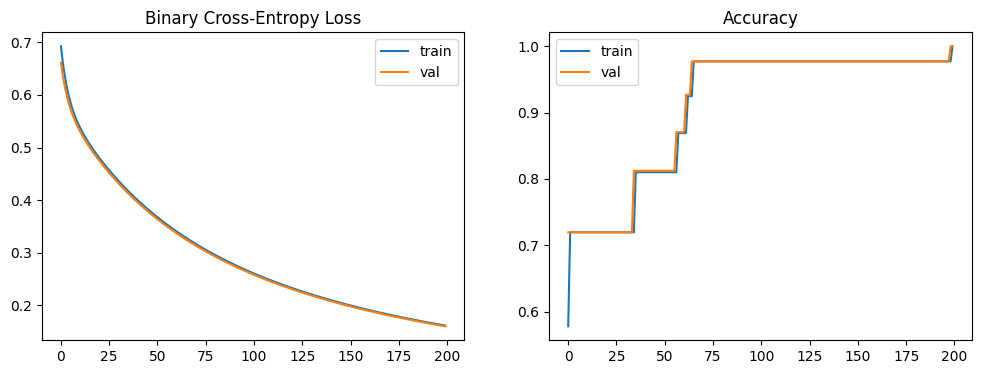

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].plot(train_losses, label='train')
axs[0].plot(val_losses, label='val')
axs[0].set_title("Binary Cross-Entropy Loss")
axs[0].legend()

axs[1].plot(train_accs, label='train')
axs[1].plot(val_accs, label='val')
axs[1].set_title("Accuracy")
axs[1].legend()

plt.show()


inspect learned weights: which chars increase vowel prob?


In [31]:
logits_per_char = w + b
char_weights = [(idx2char[i], float(logits_per_char[i])) for i in range(len(logits_per_char))]
char_weights_sorted = sorted(char_weights, key=lambda x: x[1], reverse=True)

print("Top 20 chars (highest logit -> more likely vowel):")
for ch, val in char_weights_sorted[:20]:
    print(repr(ch), f"{val:.4f}")

print("\nBottom 20 chars (lowest logit -> more likely non-vowel):")
for ch, val in char_weights_sorted[-20:]:
    print(repr(ch), f"{val:.4f}")


Top 20 chars (highest logit -> more likely vowel):
'e' 1.6456
'a' 1.1177
'o' 1.0397
'i' 0.9742
'u' 0.0038
'0' -1.2946
'_' -1.3031
'[' -1.3140
'3' -1.3197
']' -1.3280
'"' -1.3323
'*' -1.3344
')' -1.3353
'(' -1.3421
'z' -1.3436
'j' -1.3453
';' -1.3466
'q' -1.3471
'x' -1.3530
'?' -1.3707

Bottom 20 chars (lowest logit -> more likely non-vowel):
'`' -1.4913
'b' -1.5494
'p' -1.5715
"'" -1.5941
'f' -1.6409
'y' -1.6660
'm' -1.6699
'c' -1.6902
',' -1.6933
'g' -1.7188
'w' -1.7205
'\n' -1.8528
'l' -1.9482
'd' -2.0009
'r' -2.0152
's' -2.1276
'n' -2.1808
'h' -2.2299
't' -2.4573
' ' -3.2970


In [32]:
logits_per_char = w + b
char_weights = [(idx2char[i], float(logits_per_char[i])) for i in range(len(logits_per_char))]
char_weights_sorted = sorted(char_weights, key=lambda x: x[1], reverse=True)

print("Top 20 chars (highest logit -> more likely vowel):")
for ch, val in char_weights_sorted[:20]:
    print(repr(ch), f"{val:.4f}")

print("\nBottom 20 chars (lowest logit -> more likely non-vowel):")
for ch, val in char_weights_sorted[-20:]:
    print(repr(ch), f"{val:.4f}")
    

Top 20 chars (highest logit -> more likely vowel):
'e' 1.6456
'a' 1.1177
'o' 1.0397
'i' 0.9742
'u' 0.0038
'0' -1.2946
'_' -1.3031
'[' -1.3140
'3' -1.3197
']' -1.3280
'"' -1.3323
'*' -1.3344
')' -1.3353
'(' -1.3421
'z' -1.3436
'j' -1.3453
';' -1.3466
'q' -1.3471
'x' -1.3530
'?' -1.3707

Bottom 20 chars (lowest logit -> more likely non-vowel):
'`' -1.4913
'b' -1.5494
'p' -1.5715
"'" -1.5941
'f' -1.6409
'y' -1.6660
'm' -1.6699
'c' -1.6902
',' -1.6933
'g' -1.7188
'w' -1.7205
'\n' -1.8528
'l' -1.9482
'd' -2.0009
'r' -2.0152
's' -2.1276
'n' -2.1808
'h' -2.2299
't' -2.4573
' ' -3.2970
